# COMP4167 Natural Language Processing
# Practical I - Part III

In this part we will continue the work on the disaster tweet classification. Here we will:

- Transform the data to a pytorch dataset
- Build and train LSTM model in pytorch

## Step1 : Pre-process the data and split to train/test/validate

In order to use torchtext we need to save *train*, *test* and *validation* datasets into separate files. We need to:
- shuffle the data
- split the training set further into a training and validation set
- save the splits into seperate files suitable for consumption by torchtext

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import os

In [2]:
train_data_path = 'data/train.csv'
test_data_path = 'data/test.csv'
destination_folder = 'data'

In [3]:
# Split the train data further into training and validation sets
train_valid_ratio = 0.1
first_n_words = 160 # the maximum number of words to keep in the text

In [4]:
def trim_string(st):
    st = st.split(maxsplit=first_n_words)
    st = ' '.join(st[:first_n_words])
    return st

In [5]:
def prepare_csv(df_train, df_test, seed=27, val_ratio=0.3):
    idx = np.arange(df_train.shape[0])
    
    np.random.seed(int(seed))
    np.random.shuffle(idx)
    
    val_size = int(len(idx) * val_ratio)
    
    if not os.path.exists('cache'):
        os.makedirs('cache')
    
    df_train['text'] = df_train['text'].apply(trim_string)
    df_test['text'] = df_test['text'].apply(trim_string)
    
    df_train.iloc[idx[val_size:], :][['id', 'target', 'text']].to_csv(
        'cache/dataset_train.csv', index=False
    )
    
    df_train.iloc[idx[:val_size], :][['id', 'target', 'text']].to_csv(
        'cache/dataset_val.csv', index=False
    )
    
    df_test[['id','text']].to_csv('cache/dataset_test.csv',
                   index=False) # test dataset does not have a target column

In [6]:
prepare_csv(pd.read_csv(train_data_path), pd.read_csv(test_data_path), train_valid_ratio)

## Step 2: Load datasets and prepare vocabulary
Now we can reload the data we just saved using pytorch's datapipes:

In [7]:
import matplotlib.pyplot as plt
import torch
from torchtext import data
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import spacy
from torchdata.datapipes.iter import FileOpener, IterableWrapper, CSVParser
import os

/home/thomas/Documents/nlp-workshops/env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available()
                       else 'cpu')

In [9]:
def TweetClassificationDataset(root, split, shuffle=False):
    '''Dataset loading function'''
    filename = os.path.join(root, "dataset_" + split + ".csv")
    data_pipe = FileOpener([filename], encoding="utf-8") # open the file
    data_pipe = CSVParser(data_pipe, skip_lines=1)       # read it as a CSV file
    data_pipe = data_pipe.drop([0])                      # delete columns we're not using
    return data_pipe.shuffle().set_shuffle(shuffle)


print(list(TweetClassificationDataset("cache", split='train'))[:5])

[['1', "@cnni @PrisonPlanet Climate Change CNN weather 'specialist' warning:wild fires rain flooding noting about the sun? http://t.co/0sZwlWL9qU"], ['0', '@blazerfan not everyone can see ignoranceshe is Latinoand that is All she can ever benothing morebut an attack dog 4 a hate group GOP'], ['1', 'White people I know you worry tirelessly about black on black crime but what are you going to do about your mass murderer problem?'], ['0', 'Chilli heat wave Doritos never fail!'], ['0', '@BroseidonRex @dapurplesharpie I skimmed through twitter and missed this body bagging.']]


Now we can setup our tokenizer and build the vocabulary. Torchtext allows us to use a basic spacy tokenizer by calling `get_tokenizer("spacy")`. We can then build up a vocabulary of all the words in the training set.

In [10]:
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import spacy
from spacy.tokenizer import Tokenizer

train_dataset  = TweetClassificationDataset("cache", split='train', shuffle=True)
tokenizer      = get_tokenizer("spacy")

def build_vocabulary(datasets):
    for dataset in datasets:
        for _, text  in dataset:
            yield tokenizer(text.lower())

vocab = build_vocab_from_iterator(build_vocabulary([train_dataset]), min_freq=3, specials=["<pad>", "<unk>"])
vocab.set_default_index(vocab["<unk>"]) # if a word is not in the vocab - use the <unk> token

/home/thomas/Documents/nlp-workshops/env/lib/python3.10/site-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


We can now test out our tokenizer on a sample string. Notice how the out-of-vocabulary word `nlptown` is given the ID `1` in the output - this is the `<unk>` token.

In [11]:
# Test tokenizing
tokens = tokenizer("I saw a forest fire yesterday in nlptown.")
print(tokens, vocab(tokens))

['I', 'saw', 'a', 'forest', 'fire', 'yesterday', 'in', 'nlptown', '.'] [1, 424, 6, 221, 64, 1649, 7, 1, 4]


We can print out some of the vocab:

In [12]:
print(vocab.vocab.get_itos()[:200])

['<pad>', '<unk>', '#', 'the', '.', '?', 'a', 'in', 'to', ':', 'of', 'i', '-', 'and', "'", '!', '...', 'is', 'for', 'you', 'on', 'it', "'s", 'my', 'that', 'with', 'at', 'by', ';', "n't", 'this', 'from', 'are', 'be', 'have', '_', 'was', '&', 'do', 'up', 'like', 'just', 'as', 'me', '(', 'but', 'so', 'amp', 'not', 'we', ')', 'your', 'out', 'has', 'no', 'he', 'after', 'will', 'all', 'if', 'when', 'an', "'m", 'now', 'fire', 'what', 'get', 'new', 'more', 'or', 'they', '/', 'about', 'via', 'there', 'one', 'who', 'over', '2', 'been', 'how', 'people', '*', 'into', 'news', 'emergency', 'video', 'can', 'disaster', 'would', '|', 'police', '[', 'still', ']', 'burning', 'back', 'his', 'were', 'ca', 'california', "'re", 'than', 'off', 'us', 'her', 'some', 'body', 'crash', 'suicide', '..', 'storm', 'first', 'got', 'm', 'going', 'why', '3', 'buildings', 'did', 'had', 'day', 'know', 'man', 'dead', 'rt', 'today', 'fires', 'killed', 'nuclear', 'world', 'being', 'see', 'time', 'them', 'year', 'families', '

Next we can use this tokenization functionality to turn batches of data into vectors, ready to be input into the classifier. We do this using a `DataLoader`.

We pass the argument `collate_fn` to `DataLoader` - this is a function which takes a batch of data (label,text) and converts this into a input for the model. This involves tokenizing and vectorizing the data using the tokenizer we defined previously. We also add the special tokens.

In [13]:
from torch.utils.data import DataLoader, Sampler
from torchtext.data.functional import to_map_style_dataset
from torch.nn.utils.rnn import pad_sequence
import random

BATCH_SIZE = 32

train_dataset  = TweetClassificationDataset("cache", split='train', shuffle=True)
val_dataset    = TweetClassificationDataset("cache", split='val')
train_dataset, val_dataset  = to_map_style_dataset(train_dataset), to_map_style_dataset(val_dataset)
    
def vectorize_batch(batch):
    '''Take a batch of (text,label) pairs and return tensors ready for input to the model.'''
    label_list, text_list = [], []
    for (_label, _text) in batch:
        label_list.append(int(_label))
        tokens = vocab(tokenizer(_text.lower()))
        text_list.append(torch.tensor(tokens))
    return pad_sequence(text_list, padding_value=vocab.lookup_indices(["<pad>"])[0], batch_first=True), torch.tensor(label_list)    


train_loader = DataLoader(train_dataset, collate_fn=vectorize_batch, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   collate_fn=vectorize_batch, batch_size=BATCH_SIZE)

### Step 3: Build the LSTM model

For this task we will try to use an LSTM network.

First we write a new sub class to torch.nn.Module. The structure of the model is defined in the \__init__ of the class, while the forward method describes the computation of the forward pass.

The network consists of n_layers:
- an embedding layer is added to the input
- 1 LSTM layer
- a dropout is added
- a linear layer
- a final layer with sigmoid activation function

In [14]:
from torch import nn
from torch.nn import functional as F

class TEXT_LSTM(nn.Module):
    def __init__(self, dimension=64):
        super(TEXT_LSTM, self).__init__()
        self.embedding_layer = nn.Embedding(len(vocab), 300)
        self.rnn = nn.LSTM(
            input_size=300,
            hidden_size=dimension,
            num_layers=1,
            bidirectional=True,
            batch_first=True)
        self.drop = nn.Dropout(p=0.5)
        self.fc = nn.Linear(2*dimension, 1)

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        output, hidden = self.rnn(embeddings)
        text_fea = self.drop(output[:,-1])
        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea,1)
        text_out = torch.sigmoid(text_fea)
        return text_out

    
# Print out the layers
model = TEXT_LSTM()
print("Layers:")
for layer in model.children():
    print("\t{}".format(layer))

Layers:
	Embedding(3524, 300)
	LSTM(300, 64, batch_first=True, bidirectional=True)
	Dropout(p=0.5, inplace=False)
	Linear(in_features=128, out_features=1, bias=True)


### Step 4: Training

First we define a set of helper functions which will allow us to save and load our progress while training:

In [15]:
def save_checkpoint(save_path,model,optimizer,valid_loss):
    if save_path == None:
        return
    state_dict ={'model_state_dict': model.state_dict(),
                 'optimizer_state_dict': optimizer.state_dict(),
                 'valid_loss': valid_loss}
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')
    
def load_checkpoint(load_path,model,optimizer):
    if load_path == None:
        return
    state_dict = torch.load(load_path)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']

def save_metrics(save_path,train_loss_list, valid_loss_list,global_steps_list):
    if save_path==None:
        return
    state_dict= {'train_loss_list': train_loss_list,
                 'valid_loss_list': valid_loss_list,
                 'global_steps_list': global_steps_list}
    torch.save(state_dict, save_path)
    print(f'Metrics saved to ==> {save_path}')
    
def load_metrics(load_path):
    if load_path == None:
        return 
    state_dict = torch.load(load_path)
    print(f'Metrics loaded from <== {load_path}')
    return state_dict['train_loss_list'],state_dict['valid_loss_list'],state_dict['global_steps_list']

To train the model for each epoch on the training set:

- for each batch:
- do a forward pass to get model prediction
- calculate the loss
- do the backward pass to update the model parameters

To evaluate the model on the validation set:
- run the forward pass (with no_grad option)
- calculate the loss

Now we build our main training loop:

In [16]:
def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_loader,
          valid_loader = val_loader,
          num_epochs = 5,
          eval_every = len(train_loader) // 2,
          file_path = "output",
          best_valid_loss = float("Inf")):
    
    # Initial running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list=[]
    valid_loss_list = []
    global_steps_list = []
    
    # Training Loop
    model.train()
    for epoch in range(num_epochs):
        losses = []
        for text, labels in train_loader:
            # Move everything to the right device
            text   = text.to(device)
            labels = labels.to(device)
            
            # Forward pass
            output = model(text)

            # Calculate loss
            loss = criterion(output.to(torch.float32), labels.to(torch.float32))
            losses.append(loss.item())

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update running values
            running_loss += loss.item()
            global_step  += 1
            
            
            # Evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():
                    # Validation loop
                    for text, labels in valid_loader:
                        labels = labels.to(device)
                        text = text.to(device)
                        output = model(text)
                        
                        loss = criterion(output.to(torch.float32), labels.to(torch.float32))
                        valid_running_loss += loss.item()
                    
                # Evaluation
                average_train_loss = running_loss/eval_every
                average_valid_loss = valid_running_loss/len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # Resetting running values
                running_loss = 0.0
                valid_running_loss = 0.0
                model.train()

                print('Epoch[{}/{}], Step [{}/{}], Train loss:{:.4f}, Valid loss:{:.4f}'.format(
                epoch+1, num_epochs, global_step, num_epochs*len(train_loader),average_train_loss,
                    average_valid_loss))

                # Checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path+'/model.pt',model, optimizer, best_valid_loss)
                    save_metrics(file_path+'/metrics.pt',train_loss_list,valid_loss_list,global_steps_list)
                    
    save_metrics(file_path+'/metrics.pt', train_loss_list,valid_loss_list,global_steps_list)
    print('Training is Done!')
    

loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model = model.to(device)

train(model, optimizer, num_epochs=5, file_path=destination_folder)

Epoch[1/5], Step [83/835], Train loss:0.6937, Valid loss:0.6949
Model saved to ==> data/model.pt
Metrics saved to ==> data/metrics.pt
Epoch[1/5], Step [166/835], Train loss:0.6836, Valid loss:0.6630
Model saved to ==> data/model.pt
Metrics saved to ==> data/metrics.pt
Epoch[2/5], Step [249/835], Train loss:0.6626, Valid loss:0.6304
Model saved to ==> data/model.pt
Metrics saved to ==> data/metrics.pt
Epoch[2/5], Step [332/835], Train loss:0.6157, Valid loss:0.5753
Model saved to ==> data/model.pt
Metrics saved to ==> data/metrics.pt
Epoch[3/5], Step [415/835], Train loss:0.5254, Valid loss:0.5495
Model saved to ==> data/model.pt
Metrics saved to ==> data/metrics.pt
Epoch[3/5], Step [498/835], Train loss:0.5248, Valid loss:0.5194
Model saved to ==> data/model.pt
Metrics saved to ==> data/metrics.pt
Epoch[4/5], Step [581/835], Train loss:0.4304, Valid loss:0.5176
Model saved to ==> data/model.pt
Metrics saved to ==> data/metrics.pt
Epoch[4/5], Step [664/835], Train loss:0.4150, Valid los

Now the training is done, lets have a look at what happened to the training and validation losses:

Metrics loaded from <== data/metrics.pt


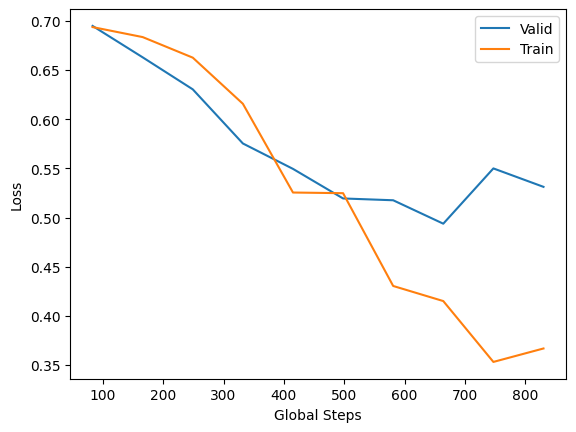

In [17]:
# Examine model training
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder+'/metrics.pt')
plt.plot(global_steps_list,valid_loss_list,label='Valid')
plt.plot(global_steps_list,train_loss_list,label='Train')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Step 5: Evaluation
Reload the best performing model from the training run and evaluate it using the sklearn evaluation tools:

In [18]:
def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []
    model.eval()
    with torch.no_grad():
        for text, labels in test_loader:
            labels = labels.to(device)
            text = text.to(device)
            #text_len = text_len.to(device)
            output = model(text)
            
            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
            
    print('Classification Report:')
    print(classification_report(y_true,y_pred,labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true,y_pred,labels=[1,0])
    ax = plt.subplot()
    sns.heatmap(cm,annot=True, ax=ax,cmap='Blues',fmt='d')
    
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicated Labels')
    ax.set_ylabel('True Labels')
    
    ax.xaxis.set_ticklabels(['Real','Irrelevant'])
    ax.yaxis.set_ticklabels(['Real','Irrelevant'])

Model loaded from <== data/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.7822    0.6423    0.7054       945
           0     0.7757    0.8737    0.8218      1338

    accuracy                         0.7779      2283
   macro avg     0.7790    0.7580    0.7636      2283
weighted avg     0.7784    0.7779    0.7736      2283



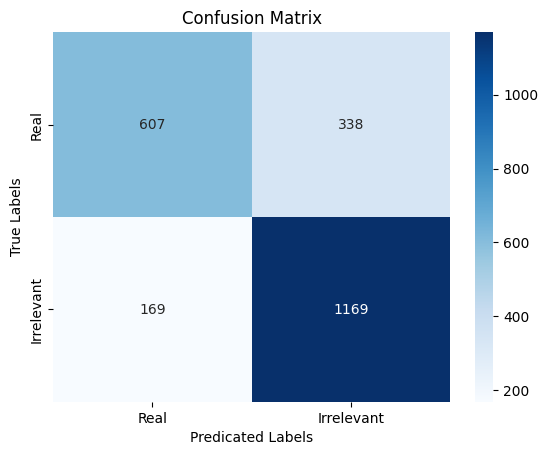

In [19]:
best_model = TEXT_LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr = 0.001)
load_checkpoint(destination_folder+'/model.pt',best_model,optimizer)
evaluate(best_model, val_loader)